# 0. Initialize

In [1]:
import gym

import torch
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
import random
import numpy as np

import matplotlib.pyplot as plt

from torch import nn #needed for building neural networks
from copy import copy, deepcopy
from collections import deque

print("Using torch version: {}".format(torch.__version__))

Using torch version: 1.5.1


# 1. 환경 불러오기 (Gym-Pendulum )

In [2]:
env_name = "Pendulum-v0"
env = gym.make(env_name)

### 환경의 state / action_dimension을 체크
- Network 의 input dimension과 output dimension을 결정하기 위함

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action space의 boundary 체크

In [4]:
action_low = env.action_space.low
action_high = env.action_space.high

In [5]:
action_low, action_high

(array([-2.], dtype=float32), array([2.], dtype=float32))

# 1-1. Main running code with random action

In [6]:
initial_state = env.reset()
  
while True:
    env.render()
    action =  np.random.uniform(low=action_low, high=action_high)
    state_next, reward, done, info = env.step(action)

    if done:
        break
env.close()

__Note__: pendulum 환경은 rendering이 있지만 우리가 사용할 환경에는 render option이 없습니다!

# 2. Agent를 만들 준비를 해볼까요?


## 2-1. Actor Network
__Actor__ : state를 기반으로 action을 만들어주는 네트워크
- input dim : dimension of state
- output dim : dimension of action

__Note__ : Actor 의 output activation은 tanh 로 사용. 

&nbsp;&nbsp;&nbsp; $\because a_t\in [-1,1]$ 으로 만들어 주기 위함

### Tanh function as an activation function 

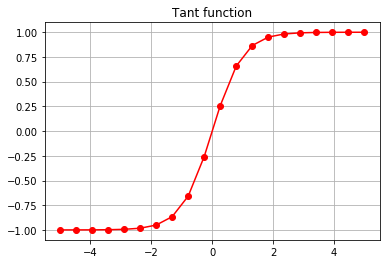

In [7]:
x = np.linspace(-5, 5, 20)
y = np.tanh(x)
plt.plot(x, y, color='red', marker="o")
plt.title("Tant function") 
plt.grid()
plt.show()

In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64]):
        super(Actor, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim] + hidden_dim
        output_dims = hidden_dim + [action_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Tanh())

    def forward(self, state):
        x = state
        for l, activation in zip(self.layers, self.activations):
            x = l(x)
            x = activation(x)
        return x

## 2-2. Critic Network

__Critic__ : state와 action을 기반으로 가치를 평가해주는 네트워크
- input dim : dimension of state + dimension of action
- output dim : 1

&nbsp;&nbsp; __Note__ : Critic 의 output activation은 None / Identity 로 사용. 

&nbsp;&nbsp;&nbsp; $\because Q(s_t,a_t)\in [-\inf,\inf]$ 으로 만들어 주기 위함

In [9]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64], output_dim=1):
        super(Critic, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim + action_dim] + hidden_dim
        output_dims = hidden_dim + [output_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Identity())

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        for l, act in zip(self.layers, self.activations):
            x = l(x)
            x = act(x)

        return x

## 2-3  Target Network 

## Target Network를 두는 이유와 update 하는 방법에 대한 수식 추가##



In [10]:
def update_model(source, target, tau):
    for src_param, target_param in zip(source.parameters(), target.parameters()):
        target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)

## 2-4 Replay Memory

__Replay Memory__: state transition:  $(s, a, r, s', terminal)$ 을 저장하는 공간

Replay memory에 포함되어야 하는 함수들

__1. push__
* input: $[s, a, r, s', terminal]$

    memory에 sample로 이루어진 list를 추가하는 함수
   

__2. sample__
* input: sample size

memory에 쌓인 transition들을 __sample size__ 만큼 sampling하는 함수

In [11]:
class ReplayMemory:
    def __init__(self, length):
        self.memory = deque(maxlen=length)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, size):
        sample = random.sample(self.memory, size)

        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4] for i in sample]

        state = np.stack(state)
        state = torch.Tensor(state).squeeze()

        next_state = np.stack(next_state)
        next_state = torch.Tensor(next_state).squeeze()

        reward = np.array(reward)
        reward = torch.tensor(reward, dtype=torch.float32).reshape(-1, 1)

        terminal = np.array(terminal).astype(int)
        terminal = torch.tensor(terminal).reshape(-1, 1)

        action = np.array(action)
        action = torch.tensor(action, dtype=torch.float32)

        return state, action, reward, next_state, terminal

## 2-5 Ornstein–Uhlenbeck process

- 시간에 따라 correlated 되어 있으며, 평균으로 회귀하는 random process
- 추후 OU noise를 통해서 exploration을 진행

__OU process__

 <div align="center"> $dx_t = \theta(\mu-x_t)dt + \sigma dW_t$ </div>


* $\theta$ 는 평균 $\mu $로 얼마나 빠르게 회귀할지를 결정하는 parameter
* $\sigma$ 는 process의 randomness를 나타내는 parameter
* $W_t$ Weiner process


__Build OU process__

In [12]:
class OUNoise:
    """
    Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
    """

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=1000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space
        self.reset()

        self.epsilon = 1.0
        self.epsilon_decay = 0.00001
        self.epsilon_min = 0.05

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state() * self.epsilon

        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, -1.0, 1.0)

#### 만들어진 OU noise 함수를 테스트해볼까요?

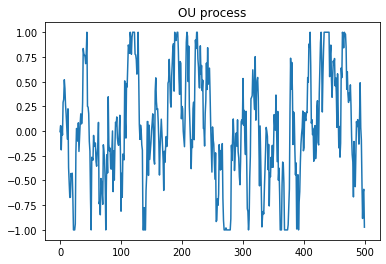

In [13]:
sample_ou_noise = OUNoise(1)
sample_ou_noise.reset()

out = []
for _ in range(500):
    out.append(sample_ou_noise.get_action(0))
    
plt.plot(out)
plt.title('OU process')
plt.show()

## 3. Let's build agent!

### Agent 에 포함되어야 하는 함수들
#### 1. get_action
* input: state
* output: action

    state를 받아서 actor을 통과시켜 action을 return하는 함수
    
#### 2. save_transition
* input: (s, a, r, s', terminal)

    memory에 transition을 저장하는 함수
    
#### 3. train_start
* output: True or False

    memory size가 batch size보다 커서 학습을 시작할 수 있는지 체크하는 함수

#### 4. fit
* output : critic loss, actor loss

    actor와 critic을 학습하는 함수

In [16]:
class DDPGAgent(nn.Module):
    def __init__(self, state_dim, action_dim, action_min, action_max, gamma=0.99):
        super(DDPGAgent, self).__init__()
        self.action_min = np.array(action_min)
        self.action_max = np.array(action_max)

        self.gamma = gamma
        self.ou_noise = OUNoise(action_dim)

        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)

        self.actor_target = Actor(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)

        update_model(self.actor, self.actor_target, tau=1.0)
        update_model(self.critic, self.critic_target, tau=1.0)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.memory = ReplayMemory(5000)
        self.batch_size = 50
        self.tau = 0.005

        self.loss_ftn = nn.MSELoss()

    def get_action(self, state, t=0):
        action_before_norm = self.actor(state).detach().numpy()
        action_before_norm = self.ou_noise.get_action(action_before_norm, t)

        action_after_norm = (action_before_norm + 1) / 2 * (self.action_max - self.action_min) + self.action_min

        return action_before_norm, action_after_norm

    def push(self, transition):
        self.memory.push(transition)

    def train_start(self):
        return len(self.memory) > self.batch_size

    def fit(self):
        state, action, reward, next_state, terminal = self.memory.sample(self.batch_size)

        next_q_val = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + self.gamma * (1 - terminal) * next_q_val
        q = self.critic(state, action)

        # Critic loss
        value_loss = self.loss_ftn(q, target_q)

        # Critic update
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        policy_loss = -self.critic(state, self.actor(state))
        policy_loss = policy_loss.mean()

        # Actor update
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        update_model(self.critic, self.critic_target, tau=self.tau)
        update_model(self.actor, self.actor_target, tau=self.tau)

        return value_loss.item(), policy_loss.item()

## 4. 이제 Agent를 학습시켜볼까요?

In [17]:
# 환경과 Agent 민들기
env_name = "Pendulum-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

agent = DDPGAgent(state_dim, action_dim, action_low, action_high)

# 환경 변수
MAX_EPISODES = 500

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state = torch.tensor(state, dtype=torch.float32)
        action, action_norm = agent.get_action(state, step)

        next_state, reward, done, info = env.step(action_norm)

        transition = [state, action, reward, next_state, done]
        
        agent.push(transition) # 매 step마다 transition을 저장해주기

        state = next_state
        episode_reward += reward

        if agent.train_start():
            critic_loss, actor_loss = agent.fit()
            
            critic_loss_epi.append(critic_loss)
            actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1

episode :    0, reward : -1426.507, critic loss : 11.040, actor loss : 7.116
episode :    1, reward : -1505.299, critic loss : 1.236, actor loss : 12.241
episode :    2, reward : -1097.201, critic loss : 1.215, actor loss : 16.313
episode :    3, reward : -1411.351, critic loss : 2.541, actor loss : 20.701
episode :    4, reward : -1174.899, critic loss : 4.589, actor loss : 26.027
episode :    5, reward : -1486.950, critic loss : 6.316, actor loss : 31.444
episode :    6, reward : -781.279, critic loss : 7.896, actor loss : 36.355
episode :    7, reward : -1105.807, critic loss : 9.629, actor loss : 39.709
episode :    8, reward : -1363.019, critic loss : 8.417, actor loss : 45.056
episode :    9, reward : -637.254, critic loss : 14.171, actor loss : 48.749
episode :   10, reward : -1037.485, critic loss : 15.766, actor loss : 51.960
episode :   11, reward : -772.784, critic loss : 16.141, actor loss : 55.596
episode :   12, reward : -1116.848, critic loss : 11.311, actor loss : 58.94

episode :  108, reward : -373.937, critic loss : 4.213, actor loss : 12.952
episode :  109, reward : -252.596, critic loss : 7.131, actor loss : 12.144
episode :  110, reward : -493.685, critic loss : 8.555, actor loss : 12.269
episode :  111, reward : -246.213, critic loss : 11.101, actor loss : 13.854
episode :  112, reward : -373.019, critic loss : 9.774, actor loss : 13.489
episode :  113, reward : -735.687, critic loss : 8.653, actor loss : 14.689
episode :  114, reward : -379.898, critic loss : 9.159, actor loss : 17.376
episode :  115, reward : -250.221, critic loss : 8.371, actor loss : 16.513
episode :  116, reward : -368.768, critic loss : 8.063, actor loss : 15.670
episode :  117, reward : -592.420, critic loss : 8.881, actor loss : 16.844
episode :  118, reward : -373.439, critic loss : 11.851, actor loss : 15.820
episode :  119, reward : -251.745, critic loss : 10.962, actor loss : 16.239
episode :  120, reward : -543.109, critic loss : 10.244, actor loss : 18.132
episode 

episode :  216, reward : -376.575, critic loss : 16.378, actor loss : 23.816
episode :  217, reward : -372.505, critic loss : 15.406, actor loss : 23.148
episode :  218, reward : -506.135, critic loss : 15.900, actor loss : 22.373
episode :  219, reward : -614.543, critic loss : 19.164, actor loss : 23.300
episode :  220, reward : -378.899, critic loss : 10.351, actor loss : 23.054
episode :  221, reward : -606.500, critic loss : 15.771, actor loss : 24.017
episode :  222, reward : -622.025, critic loss : 26.981, actor loss : 23.920
episode :  223, reward : -496.951, critic loss : 14.221, actor loss : 25.871
episode :  224, reward : -455.764, critic loss : 16.204, actor loss : 26.357
episode :  225, reward : -623.901, critic loss : 14.949, actor loss : 27.054
episode :  226, reward : -383.206, critic loss : 14.542, actor loss : 26.646
episode :  227, reward : -490.112, critic loss : 10.287, actor loss : 27.788
episode :  228, reward : -478.025, critic loss : 16.433, actor loss : 26.667

episode :  324, reward : -594.268, critic loss : 4.891, actor loss : 31.142
episode :  325, reward : -134.008, critic loss : 5.279, actor loss : 29.631
episode :  326, reward : -497.595, critic loss : 4.332, actor loss : 29.934
episode :  327, reward : -256.287, critic loss : 5.752, actor loss : 29.129
episode :  328, reward : -372.914, critic loss : 3.792, actor loss : 29.351
episode :  329, reward : -372.037, critic loss : 4.527, actor loss : 28.511
episode :  330, reward : -380.974, critic loss : 6.335, actor loss : 29.600
episode :  331, reward : -504.486, critic loss : 4.592, actor loss : 29.807
episode :  332, reward : -381.225, critic loss : 10.772, actor loss : 29.234
episode :  333, reward : -511.809, critic loss : 4.959, actor loss : 29.594
episode :  334, reward : -136.991, critic loss : 8.787, actor loss : 28.889
episode :  335, reward : -263.791, critic loss : 6.390, actor loss : 28.471
episode :  336, reward : -259.699, critic loss : 5.042, actor loss : 27.916
episode :  

episode :  432, reward : -123.194, critic loss : 3.634, actor loss : 12.926
episode :  433, reward : -116.510, critic loss : 8.109, actor loss : 12.998
episode :  434, reward : -0.732, critic loss : 4.251, actor loss : 12.130
episode :  435, reward : -122.428, critic loss : 5.610, actor loss : 11.522
episode :  436, reward : -125.769, critic loss : 4.641, actor loss : 11.766
episode :  437, reward : -118.299, critic loss : 2.785, actor loss : 11.739
episode :  438, reward : -117.401, critic loss : 4.479, actor loss : 11.013
episode :  439, reward : -240.323, critic loss : 4.664, actor loss : 10.596
episode :  440, reward : -335.677, critic loss : 2.824, actor loss : 10.992
episode :  441, reward : -249.486, critic loss : 4.887, actor loss : 10.559
episode :  442, reward : -241.208, critic loss : 1.595, actor loss : 10.506
episode :  443, reward : -115.753, critic loss : 3.048, actor loss : 10.684
episode :  444, reward : -122.931, critic loss : 4.025, actor loss : 9.772
episode :  445,

episode :  542, reward : -138.401, critic loss : 8.266, actor loss : 5.924
episode :  543, reward : -255.249, critic loss : 5.173, actor loss : 6.479
episode :  544, reward : -137.148, critic loss : 9.197, actor loss : 5.553
episode :  545, reward : -379.794, critic loss : 6.715, actor loss : 6.970
episode :  546, reward : -131.995, critic loss : 6.953, actor loss : 6.770
episode :  547, reward : -7.755, critic loss : 5.875, actor loss : 6.381
episode :  548, reward : -353.623, critic loss : 5.427, actor loss : 7.059
episode :  549, reward : -129.489, critic loss : 7.143, actor loss : 5.549
episode :  550, reward : -234.471, critic loss : 4.761, actor loss : 5.122
episode :  551, reward : -374.540, critic loss : 6.119, actor loss : 5.704
episode :  552, reward : -238.880, critic loss : 7.543, actor loss : 6.044
episode :  553, reward : -19.453, critic loss : 4.823, actor loss : 4.953
episode :  554, reward : -133.419, critic loss : 3.482, actor loss : 4.883
episode :  555, reward : -12

episode :  650, reward : -236.419, critic loss : 1.559, actor loss : -2.960
episode :  651, reward : -130.215, critic loss : 1.534, actor loss : -2.658
episode :  652, reward : -133.245, critic loss : 1.384, actor loss : -2.064
episode :  653, reward : -128.437, critic loss : 2.067, actor loss : -2.468
episode :  654, reward : -129.355, critic loss : 1.466, actor loss : -2.986
episode :  655, reward : -244.803, critic loss : 1.416, actor loss : -1.762
episode :  656, reward : -241.464, critic loss : 1.760, actor loss : -1.351
episode :  657, reward : -240.945, critic loss : 1.688, actor loss : -0.120
episode :  658, reward : -136.118, critic loss : 1.859, actor loss : -1.734
episode :  659, reward : -338.708, critic loss : 2.069, actor loss : -0.828
episode :  660, reward : -242.910, critic loss : 1.965, actor loss : -0.126
episode :  661, reward : -130.191, critic loss : 2.336, actor loss : 0.206
episode :  662, reward : -13.311, critic loss : 1.680, actor loss : -0.822
episode :  663

episode :  760, reward : -7.924, critic loss : 1.282, actor loss : 5.163
episode :  761, reward : -3.861, critic loss : 1.510, actor loss : 4.582
episode :  762, reward : -121.059, critic loss : 1.194, actor loss : 3.884
episode :  763, reward : -122.352, critic loss : 1.043, actor loss : 3.830
episode :  764, reward : -125.381, critic loss : 1.396, actor loss : 4.620
episode :  765, reward : -123.714, critic loss : 1.033, actor loss : 2.944
episode :  766, reward : -248.912, critic loss : 1.120, actor loss : 3.188
episode :  767, reward : -128.520, critic loss : 1.130, actor loss : 2.857
episode :  768, reward : -246.319, critic loss : 1.272, actor loss : 2.804
episode :  769, reward : -118.513, critic loss : 1.202, actor loss : 3.240
episode :  770, reward : -129.788, critic loss : 0.919, actor loss : 3.711
episode :  771, reward : -241.328, critic loss : 0.996, actor loss : 3.758
episode :  772, reward : -126.057, critic loss : 0.885, actor loss : 3.283
episode :  773, reward : -120

episode :  870, reward : -304.343, critic loss : 0.974, actor loss : 6.448
episode :  871, reward : -3.220, critic loss : 1.055, actor loss : 6.998
episode :  872, reward : -242.995, critic loss : 1.256, actor loss : 7.637
episode :  873, reward : -116.463, critic loss : 1.021, actor loss : 7.048
episode :  874, reward : -321.690, critic loss : 1.099, actor loss : 7.893
episode :  875, reward : -2.685, critic loss : 1.074, actor loss : 8.613
episode :  876, reward : -122.309, critic loss : 0.901, actor loss : 7.622
episode :  877, reward : -118.901, critic loss : 1.024, actor loss : 7.063
episode :  878, reward : -2.809, critic loss : 1.055, actor loss : 6.652
episode :  879, reward : -320.952, critic loss : 1.065, actor loss : 6.370
episode :  880, reward : -119.965, critic loss : 1.144, actor loss : 7.003
episode :  881, reward : -116.477, critic loss : 0.884, actor loss : 6.600
episode :  882, reward : -118.640, critic loss : 1.082, actor loss : 6.596
episode :  883, reward : -117.4

episode :  980, reward : -5.526, critic loss : 2.903, actor loss : -0.519
episode :  981, reward : -121.426, critic loss : 2.686, actor loss : -1.619
episode :  982, reward : -125.389, critic loss : 3.005, actor loss : -2.434
episode :  983, reward : -124.849, critic loss : 2.635, actor loss : -3.835
episode :  984, reward : -7.204, critic loss : 2.770, actor loss : -4.280
episode :  985, reward : -246.441, critic loss : 3.562, actor loss : -4.446
episode :  986, reward : -124.928, critic loss : 3.433, actor loss : -5.003
episode :  987, reward : -336.291, critic loss : 3.995, actor loss : -4.333
episode :  988, reward : -233.991, critic loss : 4.314, actor loss : -4.058
episode :  989, reward : -116.231, critic loss : 3.631, actor loss : -6.380
episode :  990, reward : -3.122, critic loss : 4.142, actor loss : -7.064
episode :  991, reward : -247.469, critic loss : 3.936, actor loss : -7.514
episode :  992, reward : -5.754, critic loss : 3.727, actor loss : -8.159
episode :  993, rewa

episode : 1089, reward : -132.684, critic loss : 2.574, actor loss : 0.895
episode : 1090, reward : -233.961, critic loss : 2.574, actor loss : 0.948
episode : 1091, reward : -323.326, critic loss : 2.505, actor loss : 1.057
episode : 1092, reward : -270.727, critic loss : 2.278, actor loss : 1.796
episode : 1093, reward : -131.757, critic loss : 2.796, actor loss : 1.800
episode : 1094, reward : -134.392, critic loss : 2.332, actor loss : 0.810
episode : 1095, reward : -348.782, critic loss : 2.756, actor loss : 2.463
episode : 1096, reward : -247.691, critic loss : 2.435, actor loss : 1.191
episode : 1097, reward : -233.188, critic loss : 2.301, actor loss : 2.526
episode : 1098, reward : -134.039, critic loss : 2.207, actor loss : 1.459
episode : 1099, reward : -15.265, critic loss : 2.061, actor loss : 0.937
episode : 1100, reward : -131.503, critic loss : 2.315, actor loss : 0.280
episode : 1101, reward : -14.892, critic loss : 1.820, actor loss : -0.656
episode : 1102, reward : -

episode : 1198, reward : -16.276, critic loss : 1.651, actor loss : -4.326
episode : 1199, reward : -132.210, critic loss : 1.940, actor loss : -3.741
episode : 1200, reward : -231.114, critic loss : 1.863, actor loss : -2.804
episode : 1201, reward : -132.191, critic loss : 1.649, actor loss : -2.940
episode : 1202, reward : -135.458, critic loss : 1.979, actor loss : -2.183
episode : 1203, reward : -349.550, critic loss : 1.541, actor loss : -1.779
episode : 1204, reward : -135.105, critic loss : 1.507, actor loss : -1.824
episode : 1205, reward : -131.098, critic loss : 1.499, actor loss : -1.782
episode : 1206, reward : -350.091, critic loss : 1.382, actor loss : -0.837
episode : 1207, reward : -134.739, critic loss : 2.277, actor loss : 0.038
episode : 1208, reward : -128.917, critic loss : 1.799, actor loss : -0.495
episode : 1209, reward : -133.398, critic loss : 1.752, actor loss : -0.269
episode : 1210, reward : -15.976, critic loss : 1.399, actor loss : -0.933
episode : 1211,

## 학습 되었는지 확인하기 1
- reward, critic loss, actor loss를 그려서 학습이 잘 되었는지 확인해 봅시다!

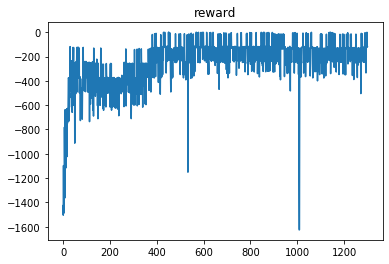

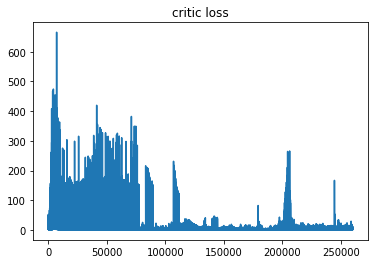

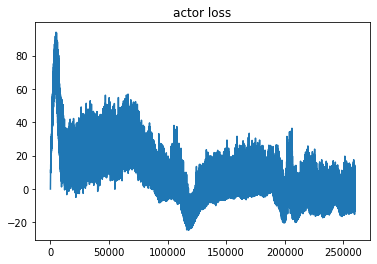

In [18]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

## 학습 되었는지 확인하기 2
- 학습된 policy를 render 해보면서 잘 학습되었는지 확인해 봅시다!

In [19]:
state = env.reset()

while True:
    
    env.render()

    state_input = torch.tensor(state, dtype=torch.float32)
    
    _, action_norm = agent.get_action(state_input)

    state, _, done, _ = env.step(action_norm)

    if done:
        break

env.close()